#### Data preparation
- 243 simulations, 3 per point in the CCD design
- Hold out 1 simulation per CCD point for testing
- From the final 50,000 steps of each simulation, take a random sample of 5,000

#### Models
$\gamma = \beta * X + \epsilon$

$Z = \beta * X + \epsilon$

$Za = \beta * X + \epsilon$

where $\gamma$ is areal density and X is the design matrix.

Predictor variables (PVs) in the design matrix are:
- slope
- R_stat multiplier
- Min rim percentage
- Effective radius multiplier
- Number of craters in the study region

In [70]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import numpy as np

from pathlib import Path
import pandas as pd

import statsmodels.api as sm

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

pio.renderers.default = "iframe"

In [122]:
base_path = "/data/saturation/central_composite_design/ccd5"
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage", "n_craters_in_study_region"]

In [123]:
# stats_df = pd.read_csv(f"{base_path}/post_saturation_sample_500.csv")
stats_df = pd.read_csv(f"{base_path}/post_saturation_sample_5000.csv")

min_max_scaler = MinMaxScaler()
stats_df[ivs] = min_max_scaler.fit_transform(stats_df[ivs])

paths = list(Path(base_path).glob("simulation_*.parquet"))
holdout_sim_dfs = [pd.read_parquet(x) for x in paths]

# metric = "areal_density"
metric = "za"
# metric = "z"

In [156]:
# Transform za using boxcox
from scipy.stats import boxcox

metric_to_transform = "za"
metric = "za_transformed"

# metric_to_transform = "areal_density"
# metric = "areal_density_transformed"

stats_df[metric] = np.log(stats_df[metric_to_transform].fillna(0) - stats_df[metric_to_transform].min() + 1)
# stats_df[metric], lmbda = boxcox(stats_df[metric_to_transform].fillna(0) - stats_df[metric_to_transform].min() + 1)
# stats_df[metric], lmbda = boxcox(stats_df[metric_to_transform])

In [149]:
# Box-Cox lambda
lmbda

-0.14250784421293938

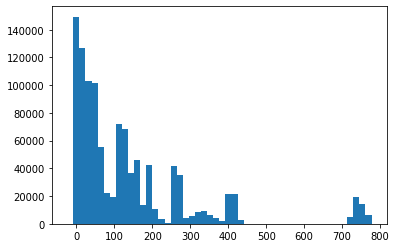

In [150]:
plt.hist(stats_df[metric_to_transform], bins=50)
plt.show()

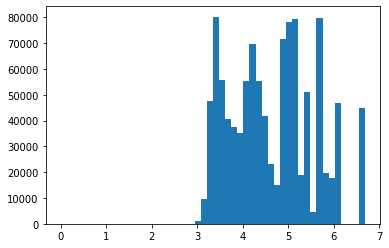

In [157]:
plt.hist(stats_df[metric], bins=50)
plt.show()

In [152]:
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1)
X = poly_transform.fit_transform(stats_df[ivs])
X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

In [153]:
# With the Box-Cox transformed target
y = stats_df[metric]

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         za_transformed   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 4.233e+06
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:19:19   Log-Likelihood:             9.1405e+05
No. Observations:             1080788   AIC:                        -1.828e+06
Df Residuals:                 1080782   BIC:                        -1.828e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
1                               3.2429      0.000    1.1e+04      0.000       3.242       3.243
slope                           0.9235      0.000   1985.489      0.000       0.923       0.924
effective_radius_multiplier    -0.4883      0.000  -1623.964      0.000      -0.489      -0.488
r_stat_multiplier              -0.0005      0.000     -1.878      0.060      -0.001    2.05e-05
min_rim_percentage             -0.2285      0.000   -842.449      0.000      -0.229      -0.228
n_craters_in_study_region       0.1267      0.001    146.714      0.000       0.125       0.128
==============================================================================
Omnibus:                    58897.059   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           194071.032
Skew:                           0.215   Prob(JB):                         0.00
Kurtosis:                       5.031   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

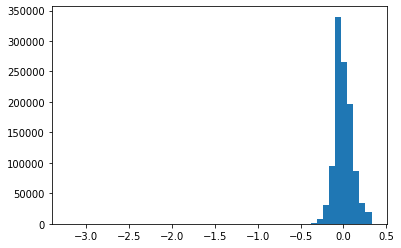

In [154]:
plt.hist(model.resid, bins=50)
plt.show()

In [141]:
# With the untransformed target
y = stats_df[metric_to_transform]

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     za   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 4.174e+06
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:16:18   Log-Likelihood:            -5.4405e+06
No. Observations:             1080788   AIC:                         1.088e+07
Df Residuals:                 1080782   BIC:                         1.088e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
1                              52.2967      0.105    498.121      0.000      52.091      52.502
slope                         -66.3616      0.166   -398.898      0.000     -66.688     -66.036
effective_radius_multiplier   -33.1071      0.108   -307.833      0.000     -33.318     -32.896
r_stat_multiplier              -1.1889      0.089    -13.326      0.000      -1.364      -1.014
min_rim_percentage            -27.3790      0.097   -282.257      0.000     -27.569     -27.189
n_craters_in_study_region     727.0617      0.309   2354.473      0.000     726.457     727.667
==============================================================================
Omnibus:                   215475.962   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           571478.182
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       5.830   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

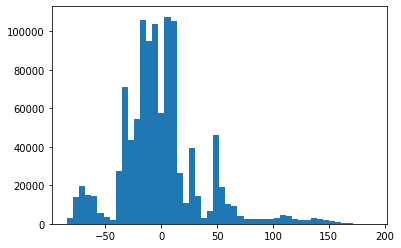

In [142]:
plt.hist(model.resid, bins=50)
plt.show()

In [64]:
holdout_index = 2
sample_cadence = 250

holdout_sim = holdout_sim_dfs[holdout_index]
holdout_sim = holdout_sim.iloc[[x * sample_cadence for x in range(holdout_sim.shape[0] // sample_cadence)]].copy()

holdout_X = holdout_sim[ivs]
holdout_X = min_max_scaler.transform(holdout_X)
holdout_X = pd.DataFrame(holdout_X, columns=min_max_scaler.get_feature_names_out())
holdout_X = poly_transform.transform(holdout_X)
holdout_X = pd.DataFrame(holdout_X, columns=poly_transform.get_feature_names_out())

holdout_X = sm.add_constant(holdout_X)

holdout_y = holdout_sim[metric_to_transform]
holdout_y = boxcox(holdout_sim[metric_to_transform].fillna(0) - stats_df[metric_to_transform].min() + 1, lmbda)

In [65]:
predictions = model.get_prediction(holdout_X)
pred_df = pd.concat([holdout_X, predictions.summary_frame(alpha=0.1)], axis=1)
pred_df["actual"] = list(holdout_y)
pred_df["n_craters"] = list(holdout_sim.index)

In [66]:
fig = go.Figure()

fig.add_scatter(x=pred_df["n_craters"],
                y=pred_df["actual"],
                mode="lines",
                name="Actual")
fig.add_scatter(x=pred_df["n_craters"],
                y=pred_df["mean"],
                mode="lines",
                name="Predicted")
fig.add_scatter(x=pred_df["n_craters"],
                y=pred_df["obs_ci_lower"],
                mode="lines",
                name="Lower 5%")
fig.add_scatter(x=pred_df["n_craters"],
                y=pred_df["obs_ci_upper"],
                mode="lines",
                name="Upper 95%")

fig.update_layout(
    xaxis_title="N Craters",
    yaxis_title=metric
)

fig.show()

In [67]:
d = pred_df.iloc[-500:]
d[d.actual < d.obs_ci_lower].shape[0] / d.shape[0]

0.0